In [ ]:
# #ModelCheckpoint callback saves a model at some interval. 
# #File name includes epoch and validation accuracy.
# filepath=r"C:\Users\panoc\Documents\thesis\Python\ModelCheckpoints\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
# #Use Mode = max for accuracy and min for loss. 
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# #https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# #This callback will stop the training when there is no improvement in
# # the validation loss for three consecutive epochs.

# #CSVLogger logs epoch, acc, loss, val_acc, val_loss
# log_csv = CSVLogger('my_logs.csv', separator=',', append=False)

# callbacks_list = [checkpoint, early_stop, log_csv]

# #SPLIT CELL HERE!!!----------------------------------------

# logs_base_dir = "./logs"
# os.makedirs(logs_base_dir, exist_ok=True)
# %tensorboard --logdir {logs_base_dir}  --host localhost

# # %tensorboard --logdir logs/fit

# # this on cmd: tensorboard --logdir=logs/
# # copy paste this on browser: http://localhost:6006/

# Setup

In [1]:
#Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from PIL import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
import datetime
%load_ext tensorboard
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(37)
random.seed(1254)
tf.random.set_seed(89)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""  # specify which GPU(s) to be used

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


#Metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


#Plot Confussion Matrix Function
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Num GPUs Available:  1


In [ ]:
#Create Train, Test, Validation Folders
os.chdir(r'C:\Users\panoc\Documents\thesis\dataset')
if os.path.isdir('train/BENIGN') is False:
    os.makedirs('train/BENIGN')
    os.makedirs('train/MALIGNANT')
    os.makedirs('valid/BENIGN')
    os.makedirs('valid/MALIGNANT')
    os.makedirs('test/BENIGN')
    os.makedirs('test/MALIGNANT')

#Distribute Images to the Corresponding Folder
os.chdir(r'C:\Users\panoc\Documents\thesis\dataset')

for i in random.sample(glob.glob(r'BENIGN\*.bmp'), 80):
    shutil.move(i, r'train\BENIGN')   
for i in random.sample(glob.glob(r'MALIGNANT\*.bmp'), 80):
    shutil.move(i, r'train\MALIGNANT')
    
for i in random.sample(glob.glob(r'BENIGN\*.bmp'), 20):
    shutil.move(i, r'valid\BENIGN')   
for i in random.sample(glob.glob(r'MALIGNANT\*.bmp'), 20):
    shutil.move(i, r'valid\MALIGNANT')
    
for i in random.sample(glob.glob(r'BENIGN\*.bmp'), 30):
    shutil.move(i, r'test\BENIGN')   
for i in random.sample(glob.glob(r'MALIGNANT\*.bmp'), 10):
    shutil.move(i, r'test\MALIGNANT')

# VGG16 Model

In [3]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
#vgg16_model.summary()

#SPLIT

os.chdir(r'C:\Users\panoc\Documents\thesis\dataset')

train_path = r'train'
valid_path = r'valid'
test_path = r'test'

train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70)


valid_batches = ImageDataGenerator() \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70)

test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70, shuffle=False)

#split


VGG16_RCM_model = tf.keras.Sequential()
for layer in vgg16_model.layers[:-1]:
    VGG16_RCM_model.add(layer)

for layer in VGG16_RCM_model.layers:
    layer.trainable = False

VGG16_RCM_model.add(tf.keras.layers.Dense(units=2, activation='sigmoid'))

VGG16_RCM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                        loss='categorical_crossentropy', 
                        metrics=['accuracy', 
                                 precision_m, 
                                 recall_m, 
                                 f1_m
                                ]
                        )

csv_logger = CSVLogger(r'C:\Users\panoc\Documents\thesis\Python\Models History\history_VGG16_RCM_TEST.log', separator=',', append=False)

history_VGG16_RCM = VGG16_RCM_model.fit(x=train_batches,
                steps_per_epoch=len(train_batches),
                validation_data=valid_batches,
                validation_steps=len(valid_batches),
                epochs=60,
                verbose=1,
                callbacks=[csv_logger]
)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3 steps, validate for 1 steps
Epoch 1/60
2/3 [===================>..........] - ETA: 6s - loss: 0.9176 - accuracy: 0.4500 - precision_m: 0.5294 - recall_m: 0.4500 - f1_m: 0.4865

ResourceExhaustedError:  OOM when allocating tensor with shape[70,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/block1_conv2/Conv2D (defined at <ipython-input-3-83ce652dbdab>:56) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_distributed_function_7195]

Function call stack:
distributed_function


In [ ]:
# evaluating the model
train_loss, train_acc, train_pre, train_rec, train_f1 = VGG16_RCM_model.evaluate(train_batches, steps=len(train_batches))
validation_loss, test_acc, test_pre, test_rec, test_f1 = VGG16_RCM_model.evaluate_generator(valid_batches, steps=len(valid_batches))
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


# plot training history
# print("Values stored in history are ... \n", history.history)
fig=plt.figure(figsize=(12,6), dpi=100)
plt.title('VGG16-RCM')
# plt.plot(history_VGG16_RCM.history['loss'], label='loss')
plt.plot(history_VGG16_RCM.history['val_loss'], label='loss')
# plt.plot(history_VGG16_RCM.history['accuracy'], label='accuracy')
plt.plot(history_VGG16_RCM.history['val_accuracy'], label='accuracy')
# plt.plot(history_VGG16_RCM.history['precision_m'], label='precision')
plt.plot(history_VGG16_RCM.history['val_precision_m'], label='precision')
# plt.plot(history_VGG16_RCM.history['recall_m'], label='recall')
plt.plot(history_VGG16_RCM.history['val_recall_m'], label='recall')
# plt.plot(history_VGG16_RCM.history['f1_m'], label='f1_m')
plt.plot(history_VGG16_RCM.history['val_f1_m'], label='f1')
plt.grid()
plt.legend(loc='upper left', prop={'size': 6})
plt.xlabel("Epochs")
plt.ylabel("Metrics Score(%)")
plt.show()


#split

predictions = VGG16_RCM_model.predict(x=test_batches, steps=len(test_batches), verbose=0)

print(np.argmax(predictions, axis=-1))

imgs, labels = next(test_batches)
print(np.argmax(labels, axis=-1))

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['Benign','Malignant']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
# tf.keras.models.save_model(model=VGG16_RCM_model, filepath = r'C:\Users\panoc\Documents\thesis\Python\Models\VGG16_RCM_model_TEST.h5')

In [ ]:
# dependencies = {
#     'recall_m': recall_m,
#     'precision_m': precision_m,
#     'f1_m': f1_m
# }

# loaded_model = tf.keras.models.load_model(r'C:\Users\panoc\Documents\thesis\Python\VGG16_RCM_model.h5', custom_objects=dependencies)


#To continue training, by modifying weights to existing model.
#The saved model can be reinstated.

# new_model = load_model('malaria_augmented_model.h5')
# results = new_model.evaluate_generator(validation_generator, steps=16)
# print(" validation loss and accuracy are", results)
# new_model.fit_generator(
#         train_generator,
#         steps_per_epoch=2000 // batch_size,    #The 2 slashes division return rounded integer
#         epochs=5,
#         validation_data=validation_generator,
#         validation_steps=800 // batch_size,
#         callbacks=callbacks_list)
# model.save('malaria_augmented_model_updated.h5') 


# #History ------------------------------------------------------------------

# #to load the data stored in this file. You can do that with pandas read_csv:

# import pandas as pd
# log_data = pd.read_csv('training.log', sep=',', engine='python')

# MobileNet

In [41]:
MobileNet = tf.keras.applications.mobilenet.MobileNet()
# MobileNet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [108]:
os.chdir(r'C:\Users\panoc\Documents\thesis\dataset')

train_path = r'train'
valid_path = r'valid'
test_path = r'test'

train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70)

valid_batches = ImageDataGenerator() \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70)

test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70, shuffle=False)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [109]:
# MobileNet_RCM = tf.keras.Sequential()
x = MobileNet.layers[-6].output

output = Dense(units=2, activation='softmax')(x)

MobileNet_RCM = tf.keras.Model(inputs=MobileNet.input, outputs=output)

for layer in MobileNet_RCM.layers[:-1]:
    layer.trainable = False

#MobileNet_RCM.summary()

MobileNet_RCM.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

csv_logger = CSVLogger(r'C:\Users\panoc\Documents\thesis\Python\Models History\history_MobileNet_RCM_TEST.log', separator=',', append=False)

In [114]:
history_MobileNet_RCM = MobileNet_RCM.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=20,
            verbose=1,
            callbacks=[csv_logger]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3 steps, validate for 1 steps
Epoch 1/20
3/3 [==============================] - 3s 1s/step - loss: 0.5659 - accuracy: 0.7250 - precision_m: 0.7310 - recall_m: 0.7310 - f1_m: 0.7310 - val_loss: 0.7125 - val_accuracy: 0.7000 - val_precision_m: 0.7000 - val_recall_m: 0.7000 - val_f1_m: 0.7000
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 0.5725 - accuracy: 0.6750 - precision_m: 0.6571 - recall_m: 0.6571 - f1_m: 0.6571 - val_loss: 0.7116 - val_accuracy: 0.7000 - val_precision_m: 0.7000 - val_recall_m: 0.7000 - val_f1_m: 0.7000
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 0.6074 - accuracy: 0.7437 - precision_m: 0.6976 - recall_m: 0.6976 - f1_m: 0.6976 - val_loss: 0.7107 - val_accuracy: 0.7000 - val_precision_m: 0.7000 - val_recall_m: 0.7000 - val_f1_m: 0.7000
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 0.5908 - accuracy: 0.6562 - precision_m: 0.6786 - recall_m

In [78]:
tf.keras.models.save_model(model=MobileNet_RCM, filepath = r'C:\Users\panoc\Documents\thesis\Python\Models\MobileNet_RCM_test.h5')

  ...
    to  
  ['...']
3/3 [==============================] - 3s 1s/step - loss: 1.3284 - accuracy: 0.4875 - precision_m: 0.4548 - recall_m: 0.4548 - f1_m: 0.4548
  ...
    to  
  ['...']
Train: 0.488, Test: 0.450


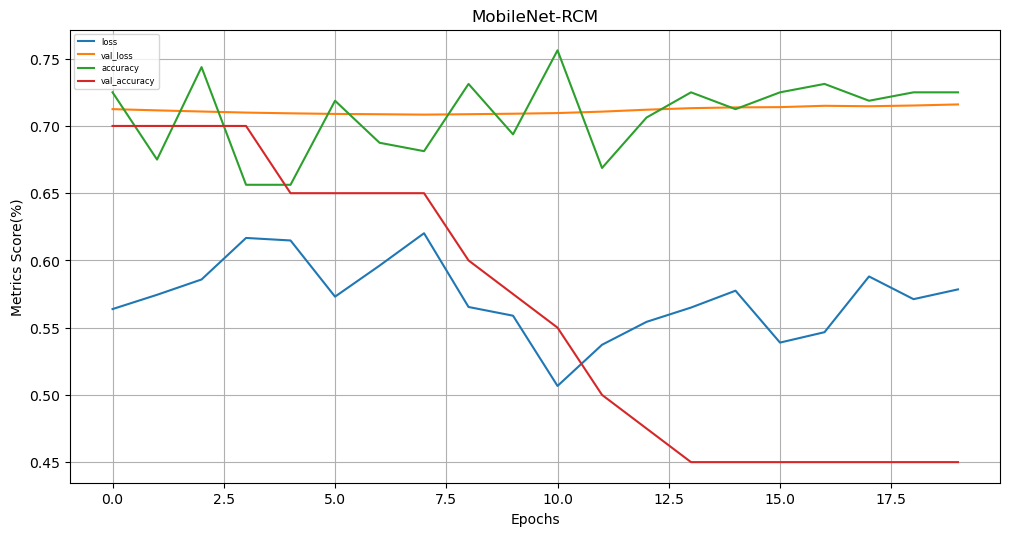

In [115]:
# evaluating the model
train_loss, train_acc, train_pre, train_rec, train_f1 = MobileNet_RCM.evaluate(train_batches, steps=len(train_batches))
validation_loss, test_acc, test_pre, test_rec, test_f1 = MobileNet_RCM.evaluate_generator(valid_batches, steps=len(valid_batches))
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


# plot training history
# print("Values stored in history are ... \n", history.history)
fig=plt.figure(figsize=(12,6), dpi=100)
plt.title('MobileNet-RCM')
plt.plot(history_MobileNet_RCM.history['loss'], label='loss')
plt.plot(history_MobileNet_RCM.history['val_loss'], label='val_loss')
plt.plot(history_MobileNet_RCM.history['accuracy'], label='accuracy')
plt.plot(history_MobileNet_RCM.history['val_accuracy'], label='val_accuracy')

plt.grid()
plt.legend(loc='upper left', prop={'size': 6})
plt.xlabel("Epochs")
plt.ylabel("Metrics Score(%)")
plt.show()

1/1 [==============================] - 0s 349ms/step
[0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0]
Confusion matrix, without normalization
[[21  9]
 [ 8  2]]


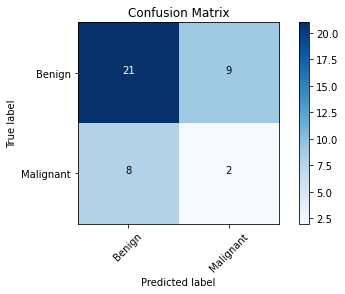

In [116]:
test_labels = test_batches.classes
predictions = MobileNet_RCM.predict(x=test_batches, steps=len(test_batches), verbose=1)
print(np.argmax(predictions, axis=-1))

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['Benign','Malignant']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# Resnet50

In [82]:
resnet50= tf.keras.applications.resnet.ResNet50()
# resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
os.chdir(r'C:\Users\panoc\Documents\thesis\dataset')

train_path = r'train'
valid_path = r'valid'
test_path = r'test'

train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70)

valid_batches = ImageDataGenerator() \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70)

test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70, shuffle=False)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [7]:
x = resnet50.layers[-2].output

output = Dense(units=2, activation='softmax')(x)

ResNet50_RCM = tf.keras.Model(inputs=resnet50.input, outputs=output)

for layer in ResNet50_RCM.layers[:-1]:
    layer.trainable = False

# ResNet50_RCM.summary()

ResNet50_RCM.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

csv_logger = CSVLogger(r'C:\Users\panoc\Documents\thesis\Python\Models History\history_ResNet50_RCM_TEST.log', separator=',', append=False)

history_ResNet50_RCM = ResNet50_RCM.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=60,
            verbose=0,
            callbacks=[csv_logger]
)

NameError: name 'resnet50' is not defined

  ...
    to  
  ['...']
3/3 [==============================] - 2s 551ms/step - loss: 0.5026 - accuracy: 0.8250 - precision_m: 0.8310 - recall_m: 0.8310 - f1_m: 0.8310
  ...
    to  
  ['...']
Train: 0.825, Test: 0.700


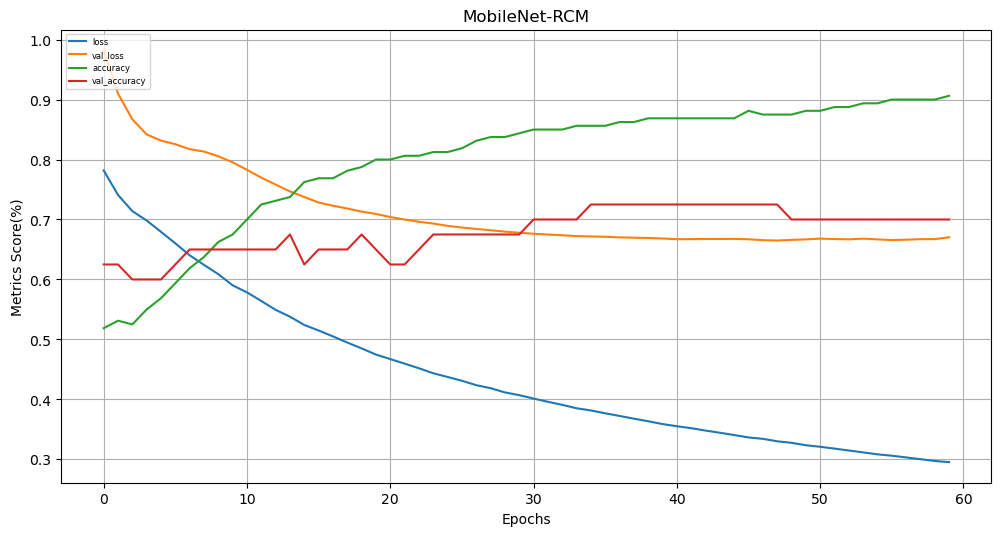

In [116]:
# evaluating the model
train_loss, train_acc, train_pre, train_rec, train_f1 = ResNet50_RCM.evaluate(train_batches, steps=len(train_batches))
validation_loss, test_acc, test_pre, test_rec, test_f1 = ResNet50_RCM.evaluate_generator(valid_batches, steps=len(valid_batches))
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


# plot training history
# print("Values stored in history are ... \n", history.history)
fig=plt.figure(figsize=(12,6), dpi=100)
plt.title('ResNet50-RCM')
plt.plot(history_ResNet50_RCM.history['loss'], label='loss')
plt.plot(history_ResNet50_RCM.history['val_loss'], label='val_loss')
plt.plot(history_ResNet50_RCM.history['accuracy'], label='accuracy')
plt.plot(history_ResNet50_RCM.history['val_accuracy'], label='val_accuracy')

plt.grid()
plt.legend(loc='upper left', prop={'size': 6})
plt.xlabel("Epochs")
plt.ylabel("Metrics Score(%)")
plt.show()

In [115]:
tf.keras.models.save_model(model=ResNet50_RCM, filepath = r'C:\Users\panoc\Documents\thesis\Python\Models\ResNet50_RCM_TEST.h5')

[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0
 1 1 0]
Confusion matrix, without normalization
[[27  3]
 [ 5  5]]


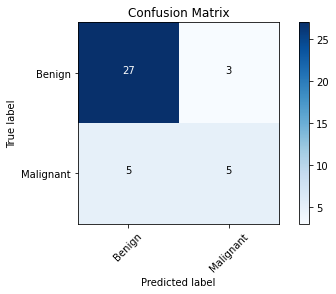

In [117]:
test_labels = test_batches.classes
predictions = ResNet50_RCM.predict(x=test_batches, steps=len(test_batches), verbose=0)
print(np.argmax(predictions, axis=-1))

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['Benign','Malignant']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# ResNet152V2

In [176]:
resnet= tf.keras.applications.resnet_v2.ResNet152V2()
# resnet.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [126]:
os.chdir(r'C:\Users\panoc\Documents\thesis\dataset')

train_path = r'train'
valid_path = r'valid'
test_path = r'test'

train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70)

valid_batches = ImageDataGenerator() \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70)

test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['BENIGN', 'MALIGNANT'], batch_size=70, shuffle=False)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [127]:
x = resnet.layers[-2].output

output = Dense(units=2, activation='softmax')(x)

ResNet152V2_RCM = tf.keras.Model(inputs=resnet.input, outputs=output)

for layer in ResNet152V2_RCM.layers[:-1]:
    layer.trainable = False

# ResNet152V2_RCM.summary()

ResNet152V2_RCM.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

csv_logger = CSVLogger(r'C:\Users\panoc\Documents\thesis\Python\Models History\history_ResNet152V2_RCM_TEST.log', separator=',', append=False)

In [128]:
history_ResNet152V2_RCM = ResNet152V2_RCM.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=60,
            verbose=1,
            callbacks=[csv_logger]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3 steps, validate for 1 steps
Epoch 1/60
3/3 [==============================] - 22s 7s/step - loss: 0.7381 - accuracy: 0.4563 - precision_m: 0.4786 - recall_m: 0.4786 - f1_m: 0.4786 - val_loss: 109.0002 - val_accuracy: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 0.5000 - val_f1_m: 0.5000
Epoch 2/60
3/3 [==============================] - 5s 2s/step - loss: 0.7664 - accuracy: 0.5000 - precision_m: 0.5119 - recall_m: 0.5119 - f1_m: 0.5119 - val_loss: 134.5604 - val_accuracy: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 0.5000 - val_f1_m: 0.5000
Epoch 3/60
3/3 [==============================] - 5s 2s/step - loss: 0.7262 - accuracy: 0.5750 - precision_m: 0.5690 - recall_m: 0.5690 - f1_m: 0.5690 - val_loss: 155.6279 - val_accuracy: 0.5000 - val_precision_m: 0.5000 - val_recall_m: 0.5000 - val_f1_m: 0.5000
Epoch 4/60
3/3 [==============================] - 5s 2s/step - loss: 0.6773 - accuracy: 0.6062 - precision_m: 0.6167 - r

  ...
    to  
  ['...']
3/3 [==============================] - 4s 1s/step - loss: 0.5713 - accuracy: 0.7250 - precision_m: 0.7548 - recall_m: 0.7548 - f1_m: 0.7548
  ...
    to  
  ['...']
Train: 0.725, Test: 0.500


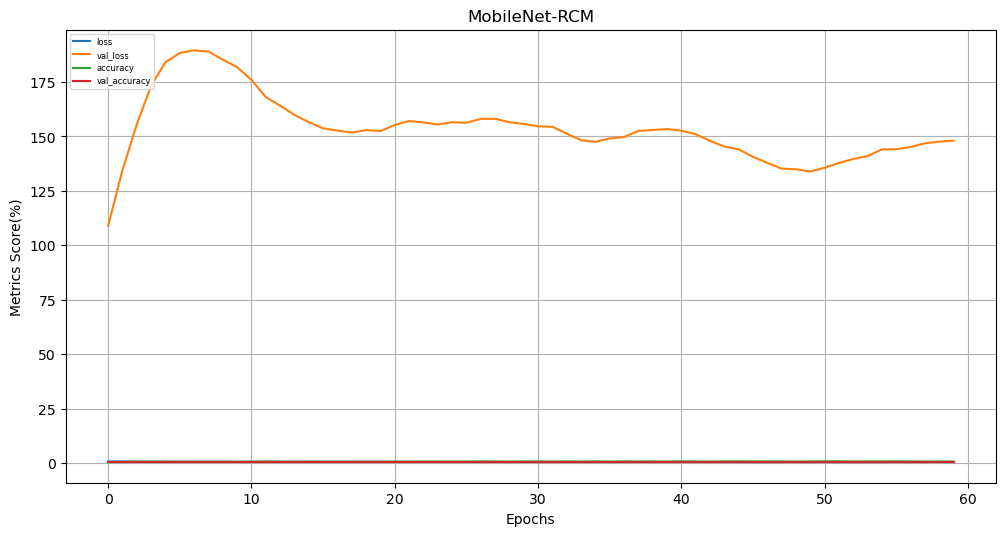

In [129]:
# evaluating the model
train_loss, train_acc, train_pre, train_rec, train_f1 = ResNet152V2_RCM.evaluate(train_batches, steps=len(train_batches))
validation_loss, test_acc, test_pre, test_rec, test_f1 = ResNet152V2_RCM.evaluate_generator(valid_batches, steps=len(valid_batches))
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


# plot training history
# print("Values stored in history are ... \n", history.history)
fig=plt.figure(figsize=(12,6), dpi=100)
plt.title('MobileNet-RCM')
plt.plot(history_ResNet152V2_RCM.history['loss'], label='loss')
plt.plot(history_ResNet152V2_RCM.history['val_loss'], label='val_loss')
plt.plot(history_ResNet152V2_RCM.history['accuracy'], label='accuracy')
plt.plot(history_ResNet152V2_RCM.history['val_accuracy'], label='val_accuracy')

plt.grid()
plt.legend(loc='upper left', prop={'size': 6})
plt.xlabel("Epochs")
plt.ylabel("Metrics Score(%)")
plt.show()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Confusion matrix, without normalization
[[30  0]
 [10  0]]


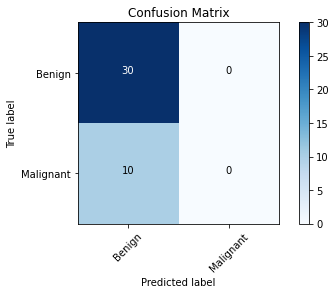

In [130]:
test_labels = test_batches.classes
predictions = ResNet152V2_RCM.predict(x=test_batches, steps=len(test_batches), verbose=0)
print(np.argmax(predictions, axis=-1))

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['Benign','Malignant']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
# tf.keras.models.save_model(model=ResNet152V2_RCM, filepath = r'C:\Users\panoc\Documents\thesis\Python\Models\ResNet152V2_RCM.h5')

# NasNetLarge

In [11]:
NNL_model= tf.keras.applications.nasnet.NASNetLarge()
# NNL_model.summary()

In [34]:
os.chdir(r'C:\Users\panoc\Documents\thesis\dataset')

train_path = r'train'
valid_path = r'valid'
test_path = r'test'

train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.nasnet.preprocess_input,
    rotation_range=45,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True) \
    .flow_from_directory(directory=train_path, target_size=(331,331), classes=['BENIGN', 'MALIGNANT'], batch_size=30)

valid_batches = ImageDataGenerator() \
    .flow_from_directory(directory=valid_path, target_size=(331,331), classes=['BENIGN', 'MALIGNANT'], batch_size=30)

test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(331,331), classes=['BENIGN', 'MALIGNANT'], batch_size=30, shuffle=False)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [28]:
x = NNL_model.layers[-2].output

output = Dense(units=2, activation='softmax')(x)

NasNetLarge_RCM = tf.keras.Model(inputs=NNL_model.input, outputs=output)

for layer in NasNetLarge_RCM.layers[:-1]:
    layer.trainable = False

# NasNetLarge_RCM.summary()

NasNetLarge_RCM.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

csv_logger = CSVLogger(r'C:\Users\panoc\Documents\thesis\Python\Models History\history_NasNetLarge_RCM_TEST.log', separator=',', append=False)

In [35]:
history_NasNetLarge_RCM = NasNetLarge_RCM.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=60,
            verbose=1,
            callbacks=[csv_logger]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 6 steps, validate for 2 steps
Epoch 1/60
6/6 [==============================] - 15s 2s/step - loss: 0.4081 - accuracy: 0.8375 - precision_m: 0.8556 - recall_m: 0.8556 - f1_m: 0.8556 - val_loss: 0.7981 - val_accuracy: 0.4000 - val_precision_m: 0.4667 - val_recall_m: 0.4667 - val_f1_m: 0.4667
Epoch 2/60
6/6 [==============================] - 15s 2s/step - loss: 0.3826 - accuracy: 0.8813 - precision_m: 0.8833 - recall_m: 0.8833 - f1_m: 0.8833 - val_loss: 0.8001 - val_accuracy: 0.3750 - val_precision_m: 0.4500 - val_recall_m: 0.4500 - val_f1_m: 0.4500
Epoch 3/60
6/6 [==============================] - 15s 2s/step - loss: 0.4045 - accuracy: 0.8438 - precision_m: 0.8500 - recall_m: 0.8500 - f1_m: 0.8500 - val_loss: 0.8005 - val_accuracy: 0.4000 - val_precision_m: 0.5000 - val_recall_m: 0.5000 - val_f1_m: 0.5000
Epoch 4/60
6/6 [==============================] - 15s 2s/step - loss: 0.3949 - accuracy: 0.8750 - precision_m: 0.8667 - reca

In [ ]:
# tf.keras.models.save_model(model=ResNet152V2_RCM, filepath = r'C:\Users\panoc\Documents\thesis\Python\Models\NasNetLarge_RCM.h5')

  ...
    to  
  ['...']
6/6 [==============================] - 11s 2s/step - loss: 0.4560 - accuracy: 0.8062 - precision_m: 0.8167 - recall_m: 0.8167 - f1_m: 0.8167
  ...
    to  
  ['...']
Train: 0.806, Test: 0.400


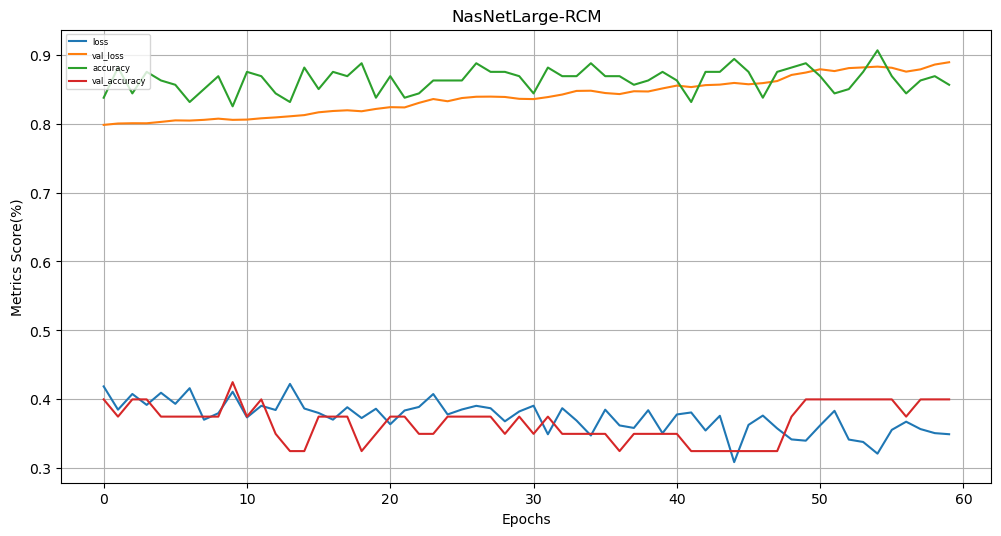

In [36]:
# evaluating the model
train_loss, train_acc, train_pre, train_rec, train_f1 = NasNetLarge_RCM.evaluate(train_batches, steps=len(train_batches))
validation_loss, test_acc, test_pre, test_rec, test_f1 = NasNetLarge_RCM.evaluate_generator(valid_batches, steps=len(valid_batches))
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


# plot training history
# print("Values stored in history are ... \n", history.history)
fig=plt.figure(figsize=(12,6), dpi=100)
plt.title('NasNetLarge-RCM')
plt.plot(history_NasNetLarge_RCM.history['loss'], label='loss')
plt.plot(history_NasNetLarge_RCM.history['val_loss'], label='val_loss')
plt.plot(history_NasNetLarge_RCM.history['accuracy'], label='accuracy')
plt.plot(history_NasNetLarge_RCM.history['val_accuracy'], label='val_accuracy')

plt.grid()
plt.legend(loc='upper left', prop={'size': 6})
plt.xlabel("Epochs")
plt.ylabel("Metrics Score(%)")
plt.show()

[1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1
 1 1 1]
Confusion matrix, without normalization
[[ 1 29]
 [ 3  7]]


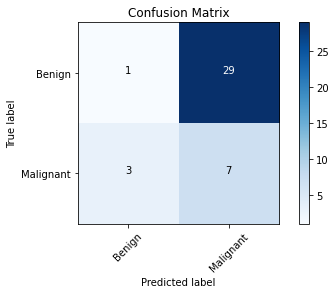

In [38]:
test_labels = test_batches.classes
predictions = NasNetLarge_RCM.predict(x=test_batches, steps=len(test_batches), verbose=0)
print(np.argmax(predictions, axis=-1))

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['Benign','Malignant']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

# InceptionResNetV2

In [44]:
IRNV2_model= tf.keras.applications.inception_resnet_v2.InceptionResNetV2()
IRNV2_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 149, 149, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_1192 (Activation)    (None, 149, 149, 32) 0           batch_normalization_203[0][0]    
________________________________________________________________________________

Total params: 55,873,736
Trainable params: 55,813,192
Non-trainable params: 60,544
__________________________________________________________________________________________________


In [45]:
os.chdir(r'C:\Users\panoc\Documents\thesis\dataset')

train_path = r'train'
valid_path = r'valid'
test_path = r'test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(299,299), classes=['BENIGN', 'MALIGNANT'], batch_size=50)
valid_batches = ImageDataGenerator() \
    .flow_from_directory(directory=valid_path, target_size=(299,299), classes=['BENIGN', 'MALIGNANT'], batch_size=50)
test_batches = ImageDataGenerator() \
    .flow_from_directory(directory=test_path, target_size=(299,299), classes=['BENIGN', 'MALIGNANT'], batch_size=50, shuffle=False)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [47]:
x = IRNV2_model.layers[-2].output

output = Dense(units=2, activation='softmax')(x)

InceptionResNetV2_RCM = tf.keras.Model(inputs=IRNV2_model.input, outputs=output)

for layer in InceptionResNetV2_RCM.layers[:-1]:
    layer.trainable = False

# InceptionResNetV2_RCM.summary()

InceptionResNetV2_RCM.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

csv_logger = CSVLogger(r'C:\Users\panoc\Documents\thesis\Python\Models History\history_InceptionResNetV2_RCM_TEST.log', separator=',', append=False)

In [51]:
history_InceptionResNetV2_RCM =  InceptionResNetV2_RCM.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=60,
            verbose=1,
            callbacks=[csv_logger]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 4 steps, validate for 1 steps
Epoch 1/60
4/4 [==============================] - 5s 1s/step - loss: 0.5171 - accuracy: 0.8250 - precision_m: 0.8400 - recall_m: 0.8400 - f1_m: 0.8400 - val_loss: 3.6908 - val_accuracy: 0.4500 - val_precision_m: 0.4500 - val_recall_m: 0.4500 - val_f1_m: 0.4500
Epoch 2/60
4/4 [==============================] - 5s 1s/step - loss: 0.5156 - accuracy: 0.8188 - precision_m: 0.8350 - recall_m: 0.8350 - f1_m: 0.8350 - val_loss: 4.7648 - val_accuracy: 0.4750 - val_precision_m: 0.4750 - val_recall_m: 0.4750 - val_f1_m: 0.4750
Epoch 3/60
4/4 [==============================] - 5s 1s/step - loss: 0.5138 - accuracy: 0.8188 - precision_m: 0.8350 - recall_m: 0.8350 - f1_m: 0.8350 - val_loss: 5.4400 - val_accuracy: 0.5250 - val_precision_m: 0.5250 - val_recall_m: 0.5250 - val_f1_m: 0.5250
Epoch 4/60
4/4 [==============================] - 5s 1s/step - loss: 0.5121 - accuracy: 0.8188 - precision_m: 0.8350 - recall_m

  ...
    to  
  ['...']
4/4 [==============================] - 4s 918ms/step - loss: 0.4743 - accuracy: 0.7625 - precision_m: 0.7700 - recall_m: 0.7700 - f1_m: 0.7700
  ...
    to  
  ['...']
Train: 0.762, Test: 0.525


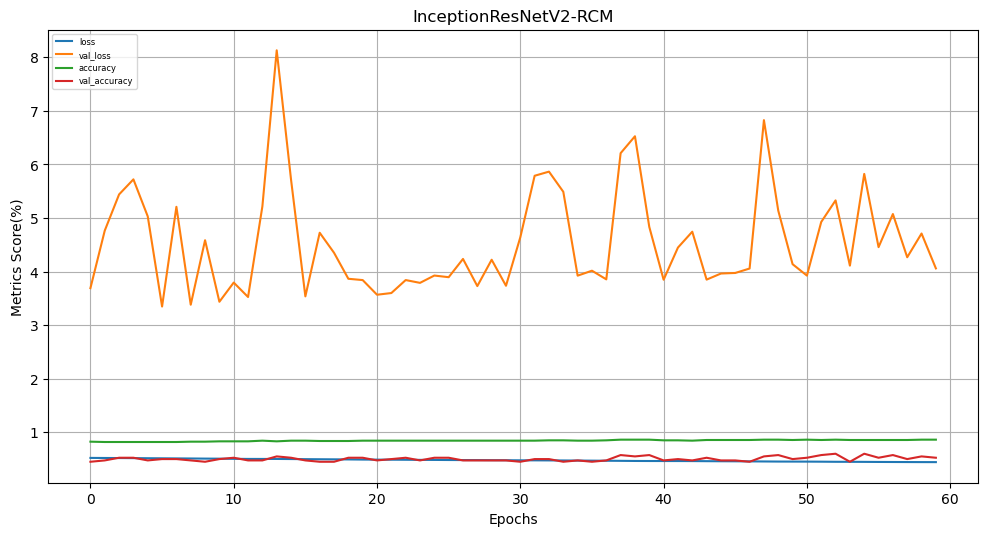

In [52]:
# evaluating the model
train_loss, train_acc, train_pre, train_rec, train_f1 = InceptionResNetV2_RCM.evaluate(train_batches, steps=len(train_batches))
validation_loss, test_acc, test_pre, test_rec, test_f1 = InceptionResNetV2_RCM.evaluate_generator(valid_batches, steps=len(valid_batches))
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))


# plot training history
# print("Values stored in history are ... \n", history.history)
fig=plt.figure(figsize=(12,6), dpi=100)
plt.title('InceptionResNetV2-RCM')
plt.plot(history_InceptionResNetV2_RCM.history['loss'], label='loss')
plt.plot(history_InceptionResNetV2_RCM.history['val_loss'], label='val_loss')
plt.plot(history_InceptionResNetV2_RCM.history['accuracy'], label='accuracy')
plt.plot(history_InceptionResNetV2_RCM.history['val_accuracy'], label='val_accuracy')

plt.grid()
plt.legend(loc='upper left', prop={'size': 6})
plt.xlabel("Epochs")
plt.ylabel("Metrics Score(%)")
plt.show()

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1
 0 1 1]
Confusion matrix, without normalization
[[24  6]
 [ 7  3]]


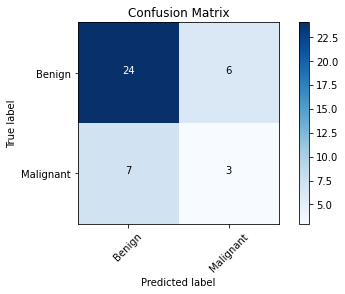

In [55]:
test_labels = test_batches.classes
predictions = InceptionResNetV2_RCM.predict(x=test_batches, steps=len(test_batches), verbose=0)
print(np.argmax(predictions, axis=-1))

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['Benign','Malignant']

plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')